In [14]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install implicit
!conda install -c conda-forge implicit
!pip install --upgrade pandas

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) 



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/bin/bash: conda: command not found
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
#Loading of dataset

movies = spark.read.csv('movies_metadata.csv', sep=",", header=True)
ratings = spark.read.csv('ratings.csv', sep=",", header=True)
credits = spark.read.csv('credits.csv', sep=",", header=True)
Df_keywords = spark.read.csv('keywords.csv', sep=",", header=True)

# 1. Data analysis

### 1.1 Movies Dataset

In [16]:
#Pre-processing of the movies's dataset

from pyspark.sql.functions import from_json
from pyspark.sql.functions import col, concat_ws
from pyspark.sql.types import StructType,ArrayType,StructField,IntegerType,StringType

schema = ArrayType(StructType([
     StructField("id", IntegerType()),
     StructField("name", StringType()) 
]))
     
# Transform the "genres" column 
movies = movies.select(col("*"), from_json(col("genres"), schema).alias("Movies_genres"))
movies = movies.withColumn('Movies_genres',movies.Movies_genres.getField("name"))
movies = movies.withColumn("Movies_genres",concat_ws(",",col("Movies_genres")))

# Transform the "belongs_to_collection" column 
movies = movies.select(col("*"), from_json(col("belongs_to_collection"), schema).alias("Movies_collection"))
movies = movies.withColumn('Movies_collection',movies.Movies_collection.getField("name"))

# Transform the "spoken_languages" column 
movies = movies.select(col("*"), from_json(col("spoken_languages"), schema).alias("Languages"))
movies = movies.withColumn('Languages',movies.Languages.getField("name"))
movies = movies.withColumn("Languages",concat_ws(",",col("Languages")))

#Changing types
movies = movies.withColumn("id", col("id").cast("integer"))
movies = movies.withColumn("popularity", col("popularity").cast("float"))
movies = movies.withColumn("vote_average", col("vote_average").cast("float"))
movies = movies.withColumn("revenue", col("revenue").cast("integer"))
movies = movies.withColumn("vote_count", col("vote_count").cast("integer"))


movies = movies.drop("genres")
movies = movies.drop("spoken_languages")
movies = movies.drop("belongs_to_collection")
movies = movies.dropna(how='any')

movies.toPandas()

,adult,budget,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,...,runtime,status,tagline,title,video,vote_average,vote_count,Movies_genres,Movies_collection,Languages
0,False,58000000,http://www.mgm.com/view/movie/757/Goldeneye/,710,tt0113189,en,GoldenEye,James Bond must unmask the mysterious head of ...,14.686036,/5c0ovjT41KnYIHYuF4AWsTe3sKh.jpg,...,130.0,Released,No limits. No fears. No substitutes.,GoldenEye,False,6.6,1194,"Adventure,Action,Thriller",[James Bond Collection],"English,Pусский,Español"
1,False,3500000,http://www.newline.com/properties/friday.html,10634,tt0113118,en,Friday,Craig and Smokey are two guys in Los Angeles h...,14.569650,/kkoGT4bnK5oGiNbzGGcXzrXMSxn.jpg,...,91.0,Released,A lot can go down between thursday and saturda...,Friday,False,7.0,513,Comedy,[Friday Collection],English
2,False,19000000,http://www.miramax.com/movie/from-dusk-till-dawn/,755,tt0116367,en,From Dusk Till Dawn,Seth Gecko and his younger brother Richard are...,15.339153,/ce0d4kM5KxT4x1Oq8JkSuNYevri.jpg,...,108.0,Released,One night is all that stands between them and ...,From Dusk Till Dawn,False,6.9,1644,"Horror,Action,Thriller,Crime",[From Dusk Till Dawn Collection],"English,Español"
3,False,2000000,http://miramax.com/movie/blue-in-the-face/,5894,tt0112541,en,Blue in the Face,"Auggie runs a small tobacco shop in Brooklyn, ...",11.528147,/qa9yf3OlfXbYBb0af0mpawGB6TI.jpg,...,83.0,Released,Welcome to the planet Brooklyn.,Blue in the Face,False,6.8,28,Comedy,[Brooklyn Cigar Store Collection],English
4,False,15000000,http://www.powerrangers.com/,9070,tt0113820,en,Mighty Morphin Power Rangers: The Movie,Power up with six incredible teens who out-man...,7.024227,/A3ijhraMN0tvpDnPoyVP7NulkSr.jpg,...,92.0,Released,The Power Is On!,Mighty Morphin Power Rangers: The Movie,False,5.2,153,"Action,Adventure,Science Fiction,Family,Fantasy",[Power Rangers Collection],English
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
546,False,0,http://www.monsterhigh13wishes.com,212470,tt3159812,en,Monster High: 13 Wishes,"It’s a new school year at Monster High™, and t...",3.527047,/smWPHu8UWlVr6pJkExPrF4fks0x.jpg,...,73.0,Released,Be scare-ful what you wish for,Monster High: 13 Wishes,False,6.4,20,"Family,Fantasy,Music,Animation",[Monster High Collection],English
547,False,80000000,http://www.despicable.me,324852,tt3469046,en,Despicable Me 3,Gru and his wife Lucy must stop former '80s ch...,36.631519,/5qcUGqWoWhEsoQwNUrtf3y3fcWn.jpg,...,96.0,Released,Oh brother.,Despicable Me 3,False,6.2,2002,"Action,Animation,Adventure,Family,Comedy",[Despicable Me Collection],English
548,False,0,https://web.archive.org/web/20160111092554/htt...,294682,tt3474600,ja,リトル・フォレスト 夏・秋,"Abandoned by her mother, young Ichiko leaves h...",1.252833,/87FWLJdViF9p8vysGBFcXMXXlZp.jpg,...,111.0,Released,Back to nature.,Little Forest: Summer/Autumn,False,8.3,16,Drama,[Little Forest Collection],日本語
549,False,152000000,http://www.foxmovies.com/movies/war-for-the-pl...,281338,tt3450958,en,War for the Planet of the Apes,Caesar and his apes are forced into a deadly c...,146.161789,/3vYhLLxrTtZLysXtIWktmd57Snv.jpg,...,140.0,Released,For freedom. For family. For the planet.,War for the Planet of the Apes,False,6.7,1675,"Drama,Science Fiction,War",[Planet of the Apes (Reboot) Collection],English


In [17]:
movies.printSchema()

root
 |-- adult: string (nullable = true)
 |-- budget: string (nullable = true)
 |-- homepage: string (nullable = true)
 |-- id: integer (nullable = true)
 |-- imdb_id: string (nullable = true)
 |-- original_language: string (nullable = true)
 |-- original_title: string (nullable = true)
 |-- overview: string (nullable = true)
 |-- popularity: float (nullable = true)
 |-- poster_path: string (nullable = true)
 |-- production_companies: string (nullable = true)
 |-- production_countries: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- revenue: integer (nullable = true)
 |-- runtime: string (nullable = true)
 |-- status: string (nullable = true)
 |-- tagline: string (nullable = true)
 |-- title: string (nullable = true)
 |-- video: string (nullable = true)
 |-- vote_average: float (nullable = true)
 |-- vote_count: integer (nullable = true)
 |-- Movies_genres: string (nullable = false)
 |-- Movies_collection: array (nullable = true)
 |    |-- element: string (co

In [18]:
movies.describe()

summary,adult,budget,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,status,tagline,title,video,vote_average,vote_count,Movies_genres,Languages
count,551,551,551,551,551,551,551,551,551,551,551,551,551,551,551,551,551,551,551,551,551,551,551
mean,null,5.868250124682396E7,null,74746.75680580763,null,null,null,null,16.64542572003174,null,null,null,null,2.616739268584392E8,108.72595281306715,null,null,null,null,6.2735027276020086,1875.4500907441015,null,null
stddev,null,6.898453305288473E7,null,102855.71834744941,null,null,null,null,31.56893702829827,null,null,null,null,3.301224269221208E8,27.82025484736462,null,null,null,null,1.0175667453368118,2234.124765937942,null,null
min,False,0,http://alphaandom...,11,tt0032455,cn,12 Rounds,"""A spoof of all t...",0.003741,/11X9WnPuSCnKavfT...,[],[],1940-11-13,0,100.0,Released,1 Ruthless Crime ...,12 Rounds,False,0.0,0,Action,
max,False,994000,https://www.warne...,426580,tt6078822,zh,친절한 금자씨,Ángela Vidal the ...,547.4883,/zpaQwR0YViPd83bx...,[{'name': 'Zentro...,[{'iso_3166_1': '...,2017-07-11,2068223624,99.0,Released,you asked for it,xXx: State of the...,False,8.5,12269,Western,"普通话,日本語,广州话 / 廣州話"


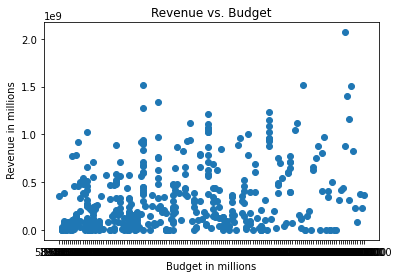

In [19]:
import matplotlib.pyplot as plt

# Plot a scatter plot of movie budgets and revenues
budgets = movies.select("budget").rdd.flatMap(lambda x: x).collect()
revenues = movies.select("revenue").rdd.flatMap(lambda x: x).collect()
plt.scatter(budgets, revenues)
plt.title("Revenue vs. Budget")
plt.xlabel("Budget in millions")
plt.ylabel(" Revenue in millions")
plt.show()

We have a distribution of the movies budget according to their revenue

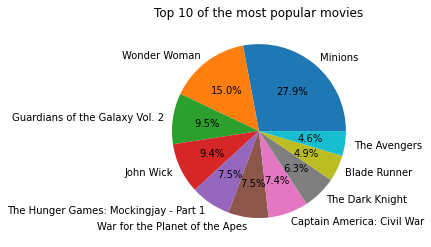

In [20]:
top_movies = movies.orderBy(movies.popularity.desc()).limit(10)
top_movies_pd = top_movies.toPandas()


plt.pie(top_movies_pd.popularity, labels=top_movies_pd.title, autopct='%1.1f%%')
plt.title('Top 10 of the most popular movies')
plt.show()

Here, the pie chart displays the 10 most popular movies according to the popularity parameter. Thanks to the percentage we know that "Wonder Woman" is the most popular movie

In [22]:
from pyspark.sql.functions import desc

LanguageCol = movies.select('Languages')
language_counts = LanguageCol.groupBy('Languages').count().orderBy(desc('count'))
most_spoken_language = language_counts.first()['Languages']
print(most_spoken_language)

English


With the following code we can admit that the most spoke language in the movies dataset in English

###1.2 Ratings Dataset

In [23]:
ratings = ratings.withColumn("userId", col("userId").cast("integer"))
ratings = ratings.withColumn("movieId", col("movieId").cast("integer"))
ratings = ratings.withColumn("rating", col("rating").cast("integer"))

ratings.show()

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|    110|     1|1425941529|
|     1|    147|     4|1425942435|
|     1|    858|     5|1425941523|
|     1|   1221|     5|1425941546|
|     1|   1246|     5|1425941556|
|     1|   1968|     4|1425942148|
|     1|   2762|     4|1425941300|
|     1|   2918|     5|1425941593|
|     1|   2959|     4|1425941601|
|     1|   4226|     4|1425942228|
|     1|   4878|     5|1425941434|
|     1|   5577|     5|1425941397|
|     1|  33794|     4|1425942005|
|     1|  54503|     3|1425941313|
|     1|  58559|     4|1425942007|
|     1|  59315|     5|1425941502|
|     1|  68358|     5|1425941464|
|     1|  69844|     5|1425942139|
|     1|  73017|     5|1425942699|
|     1|  81834|     5|1425942133|
+------+-------+------+----------+
only showing top 20 rows



In [24]:
ratings.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: integer (nullable = true)
 |-- timestamp: string (nullable = true)



In [25]:
ratings.describe()

summary,userId,movieId,rating,timestamp
count,15505234,15505234,15505234,15505234
mean,80280.32473802072,15830.632649787807,3.3882208420717803,1.1714064313730137E9
stddev,46501.66489997914,31076.324581727415,1.1105793547489442,2.054220235676997E8
min,1,1,0,1000000065
max,161367,176271,5,999999978


### 1.3 Credits Dataset

In [26]:
credits.show()

+--------------------+--------------------+--------------------+
|                cast|                crew|                  id|
+--------------------+--------------------+--------------------+
|[{'cast_id': 14, ...|"[{'credit_id': '...| 'profile_path': ...|
|[{'cast_id': 1, '...|[{'credit_id': '5...|                8844|
|[{'cast_id': 2, '...|[{'credit_id': '5...|               15602|
|"[{'cast_id': 1, ...| 'credit_id': '52...|         'gender': 1|
|[{'cast_id': 1, '...|[{'credit_id': '5...|               11862|
|"[{'cast_id': 25,...| 'credit_id': '52...|         'gender': 0|
|[{'cast_id': 1, '...|[{'credit_id': '5...|               11860|
|[{'cast_id': 2, '...|[{'credit_id': '5...|               45325|
|[{'cast_id': 1, '...|[{'credit_id': '5...|                9091|
|[{'cast_id': 1, '...|[{'credit_id': '5...|                 710|
|"[{'cast_id': 1, ...| 'credit_id': '52...|         'gender': 2|
|[{'cast_id': 9, '...|"[{'credit_id': '...| 'profile_path': ...|
|"[{'cast_id': 1, ...| 'c

In [27]:
credits.printSchema()

root
 |-- cast: string (nullable = true)
 |-- crew: string (nullable = true)
 |-- id: string (nullable = true)



In [28]:
credits.describe()

summary,cast,crew,id
count,45476,45475,45476
mean,null,null,119814.64303772531
stddev,null,null,116289.69179108253
min,"""[{'cast_id': 0, ...","""""Kagami jigoku""""","""""Kasei no unga"""""
max,"[{'cast_id': 96, ...",[{'credit_id': '5...,"Ali (voice)"""""


### 1.4 Keywords Dataset

In [29]:
Df_keywords.printSchema()

root
 |-- id: string (nullable = true)
 |-- keywords: string (nullable = true)



In [30]:
Df_keywords.show()

+-----+--------------------+
|   id|            keywords|
+-----+--------------------+
|  862|[{'id': 931, 'nam...|
| 8844|"[{'id': 10090, '...|
|15602|[{'id': 1495, 'na...|
|31357|[{'id': 818, 'nam...|
|11862|[{'id': 1009, 'na...|
|  949|[{'id': 642, 'nam...|
|11860|[{'id': 90, 'name...|
|45325|                  []|
| 9091|[{'id': 949, 'nam...|
|  710|[{'id': 701, 'nam...|
| 9087|[{'id': 833, 'nam...|
|12110|[{'id': 3633, 'na...|
|21032|[{'id': 1994, 'na...|
|10858|[{'id': 840, 'nam...|
| 1408|[{'id': 911, 'nam...|
|  524|[{'id': 383, 'nam...|
| 4584|[{'id': 420, 'nam...|
|    5|"[{'id': 612, 'na...|
| 9273|[{'id': 409, 'nam...|
|11517|[{'id': 380, 'nam...|
+-----+--------------------+
only showing top 20 rows



In [31]:
Df_keywords.describe()

summary,id,keywords
count,46419,46419
mean,109769.95187315538,null
stddev,113045.78025568495,null
min,100,"""[{'id': 1005, 'n..."
max,9999,"[{'id': 9991, 'na..."


#2. Build regression model

In [32]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression


numeric_cols=['vote_average','vote_count','revenue']

assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features", handleInvalid = "skip")
df_assembler = assembler.transform(movies)

train, test = movies.randomSplit([0.8, 0.2])
train = assembler.transform(train)
test = assembler.transform(test)
lr = LinearRegression(featuresCol='features', labelCol="revenue")
lr_model = lr.fit(train)

# make predictions on the testing data
predictions = lr_model.transform(test)

# evaluate the model using a regression evaluator
# Evaluate the model
evaluator = RegressionEvaluator(labelCol="revenue", predictionCol="prediction", metricName="mse")
mse = evaluator.evaluate(predictions)
print("Mean Squared Error (MSE) on test data = %g" % mse)

Mean Squared Error (MSE) on test data = 4.41645e-15


In [33]:
print(predictions)

+-----+---------+--------------------+------+---------+-----------------+----------------------------+--------------------+----------+--------------------+--------------------+--------------------+------------+---------+-------+--------+--------------------+--------------------+-----+------------+----------+--------------------+--------------------+---------------------------+--------------------+--------------------+
|adult|   budget|            homepage|    id|  imdb_id|original_language|              original_title|            overview|popularity|         poster_path|production_companies|production_countries|release_date|  revenue|runtime|  status|             tagline|               title|video|vote_average|vote_count|       Movies_genres|   Movies_collection|                  Languages|            features|          prediction|
+-----+---------+--------------------+------+---------+-----------------+----------------------------+--------------------+----------+--------------------+-

On the two last columns we have respectively the prediction of movies revenue and their ratings

# 3.1 Suggest top N movies

In [36]:
from pyspark.ml.feature import StringIndexer
from pyspark.sql.types import ArrayType, StringType
from pyspark.sql.functions import col, explode, udf
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import array_contains

movies = movies.drop("TitleIndex")

title_indexer = StringIndexer(inputCol="title", outputCol="TitleIndex")
title_index_model = title_indexer.fit(movies)
movies = title_index_model.transform(movies)

In [37]:
from pyspark.sql.functions import col, explode
from pyspark.sql.types import ArrayType, StringType
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import array_contains


# Join ratings and movies dataframes on movies.id and ratings.movieId 
df_joined = movies.join(ratings, movies.id == ratings.movieId, "inner")

# Build the ALS model
als = ALS(maxIter=5, regParam=0.01, userCol="userId", itemCol="TitleIndex", ratingCol="rating",
          coldStartStrategy="drop")
model = als.fit(df_joined)

# Get the movieId for the given movie title
given_movie_title = "Toy Story (1995)"
given_movie_title_normalized = given_movie_title.strip().lower()

given_movie_id = movies.filter(col("title").lower() == given_movie_title_normalized).select("id").first()['id']
given_movie_genres = movies.filter(col("id") == given_movie_id).select("Movies_genres").collect()[0][0]

related_movies = movies.filter(array_contains(col("Movies_genres"), given_movie_genres[0]))
for genre in given_movie_genres[1:]:
    related_movies = related_movies.union(movies.filter(array_contains(col("Movies_genres"), genre)))

# Get the recommendations for each related movie
related_movie_ids = related_movies.select("TitleIndex").distinct()
related_movie_recs = model.recommendForItemSubset(related_movie_ids, 10)

# Explode the recommendations to get one row per recommendation
exploded_recs = related_movie_recs.select("TitleIndex", explode("recommendations"))

# Join with the movie titles and sort by the recommendation score
sorted_recs = exploded_recs.join(movies.select("TitleIndex", "title"), "TitleIndex").orderBy("col.rating", ascending=False)

# Select the top 10 recommended movies
top_recs = sorted_recs.select("title").distinct().limit(10)

# Show the recommendations
top_recs.show(truncate=False)


TypeError: ignored

# 3.2 Predict users rating

In [38]:
from pyspark.sql.functions import col

# Join dataframes on the movies Id column
joined_df = movies.join(ratings, movies.id == ratings.movieId, "inner")

In [39]:
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS


(training, test) = df_joined.randomSplit([0.8, 0.2], seed=1234)

als = ALS(maxIter=5, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop")
model = als.fit(training)
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))
userRecs = model.recommendForAllUsers(10)
user_id = 1
users = spark.createDataFrame([(user_id,)], ["userId"])
userRecs = model.recommendForUserSubset(users, 10).collect()[0]["recommendations"]

a = [row["movieId"] for row in userRecs]
b = df_joined.filter(df_joined.movieId.isin(a))
recommended_movies_titles = b.select("title","rating","userId").show()

Root-mean-square error = 1.5528594018841206
+--------------------+------+------+
|               title|rating|userId|
+--------------------+------+------+
|       Trainspotting|     4|   117|
|       Trainspotting|     5|   123|
|       Trainspotting|     2|   142|
|       Trainspotting|     4|   193|
|On Her Majesty's ...|     5|   337|
|       Trainspotting|     3|   430|
|       Trainspotting|     2|   463|
|       Trainspotting|     3|   482|
|       Trainspotting|     4|   487|
|On Her Majesty's ...|     5|   543|
|On Her Majesty's ...|     5|   557|
|       Trainspotting|     3|   611|
|Pirates of the Ca...|     3|   611|
|       Trainspotting|     3|   619|
|On Her Majesty's ...|     3|   625|
|On Her Majesty's ...|     4|   832|
|Pirates of the Ca...|     3|   887|
|Underworld: Evolu...|     4|   988|
|       Trainspotting|     1|  1030|
|On Her Majesty's ...|     5|  1097|
+--------------------+------+------+
only showing top 20 rows

